In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime, timedelta
from scipy.optimize import minimize 

In [2]:
START_DATE = "2019-01-01"
END_DATE = datetime.today().strftime("%Y-%m-%d")
#END_DATE = "2020-11-10"

In [3]:
def stock_price():
    #Creates the dataset containing all stock prices and S&P 500 price "SPY"
    ticker_list = pd.read_csv("invest_list.csv")["0"].to_list() + ['SPY']
    
    # Get all Adjusted Close prices for all the tickers in our list,
    # between START_DATE and END_DATE
    all_data = pdr.get_data_yahoo(ticker_list, start=START_DATE, end=END_DATE)
    stock_raw_data = all_data["Adj Close"]
    
    #Remove rows with null price data
    stock_raw_data.dropna(how="any", axis=0, inplace=True)
    
    # Adding weekday number 
    weekday = []
    for day in stock_raw_data.index:
        weekday.append(day.weekday())
    stock_raw_data["weekday"] = weekday
    
    return stock_raw_data

In [4]:
stock_raw_data = stock_price()

<ipython-input-3-726fe7df4f83>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_raw_data.dropna(how="any", axis=0, inplace=True)
<ipython-input-3-726fe7df4f83>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_raw_data["weekday"] = weekday


In [5]:
stock_raw_data.tail()
#stock_new

Symbols,BE,TWLO,ZM,SLP,DKNG,SPY,weekday
Date,,,,,,,
2020-11-30,24.520000,320.089996,478.359985,55.970001,52.360001,362.059998,0
2020-12-01,24.620001,313.579987,406.309998,56.400002,50.779999,366.019989,1
2020-12-02,24.260000,320.339996,412.859985,56.070000,51.099998,366.790009,2
2020-12-03,24.200001,319.750000,413.540009,55.880001,50.060001,366.690002,3
2020-12-04,27.370001,319.579987,411.260010,56.970001,49.625599,369.059998,4


In [6]:
#Weight Optimization
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(portfolio.mean()*weights)
    vol = np.sqrt(np.dot(weights.T,np.dot(portfolio.cov(),weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])
#minimize negative sharpe ratio
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1
# add constriant:check allocation sums to 1
def check_sum(weights):
    return np.sum(weights) - 1

In [7]:
def Optimization():
# create constraint variable: an equition type of constrant. fun: pass in the function: check_sum
    cons = ({'type':'eq','fun':check_sum})
# create weight boundaries
    bounds = ((0,1),(0,1),(0,1),(0,1),(0,1))
# initial guess to start with
    init_guess = [0.2, 0.2, 0.2, 0.2, 0.2]
    opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    return opt_results

In [8]:
def get_holding(total, weights):
    s1_w, s2_w, s3_w, s4_w, s5_w = weights
            
    s1_h = (total * s1_w) / BE_Price
    s2_h = (total * s2_w) / TWLO_Price
    s3_h = (total * s3_w) / ZM_Price
    s4_h = (total * s4_w) / SLP_Price
    s5_h = (total * s5_w) / DKNG_Price
    
    return s1_h.round(0), s2_h.round(0), s3_h.round(0), s4_h.round(0), s5_h.round(0)

In [9]:
#Main
stock_new = stock_raw_data.copy()

initial_value = 10000

BE_Weight = []
TWLO_Weight = []
ZM_Weight = []
SLP_Weight = []
DKNG_Weight = []

BE_Holding = []
TWLO_Holding = []
ZM_Holding = []
SLP_Holding = []
DKNG_Holding = []

Portfolio = []
SPY_Bench = []
SPY_Holding = initial_value/stock_new["SPY"][0]
SPY_Holding = SPY_Holding.round(0)

for i in range(stock_new.shape[0]):
#for i in range(20):
    
    BE_Price = stock_new["BE"][i]
    TWLO_Price = stock_new["TWLO"][i]
    ZM_Price = stock_new["ZM"][i]
    SLP_Price = stock_new["SLP"][i]
    DKNG_Price = stock_new["DKNG"][i]
    SPY_Price = stock_new["SPY"][i]
    
    if i == 0:
        #Initial Value
        total = initial_value
    else:
        #Calculate Protofilo Value
        total = BE_Price*s1_h + TWLO_Price*s2_h + ZM_Price*s3_h + SLP_Price*s4_h + DKNG_Price*s5_h
    Portfolio.append(total)
    
    SPY_Bench.append(SPY_Holding*SPY_Price)
    
    #Exeaute Strategy
    # weekday[i] == 1, 1 is for Tuesday
    #if stock_new.weekday[i] == 1 or stock_new.weekday[i] == 3 or i == 0:
    if stock_new.weekday[i] == 1 or i == 0:
        reg_return = stock_new.iloc[i-20:i,:5]
        portfolio = np.log(reg_return/reg_return.shift(1))
        opt_results = Optimization()
        s1_h, s2_h, s3_h, s4_h, s5_h = get_holding(total, opt_results.x)
    
    BE_Weight.append(opt_results.x[0].round(2))
    TWLO_Weight.append(opt_results.x[1].round(2))
    ZM_Weight.append(opt_results.x[2].round(2))
    SLP_Weight.append(opt_results.x[3].round(2))
    DKNG_Weight.append(opt_results.x[4].round(2))

    BE_Holding.append(s1_h)
    TWLO_Holding.append(s2_h)
    ZM_Holding.append(s3_h)
    SLP_Holding.append(s4_h)
    DKNG_Holding.append(s5_h)

stock_new["BE_Weight"] = BE_Weight
stock_new["TWLO_Weight"] = TWLO_Weight
stock_new["ZM_Weight"] = ZM_Weight
stock_new["SLP_Weight"] = SLP_Weight
stock_new["DKNG_Weight"] = DKNG_Weight

stock_new["BE_Holding"] = BE_Holding
stock_new["TWLO_Holding"] = TWLO_Holding
stock_new["ZM_Holding"] = ZM_Holding
stock_new["SLP_Holding"] = SLP_Holding
stock_new["DKNG_Holding"] = DKNG_Holding

stock_new["Portfolio"] = Portfolio
stock_new["SPY_Bench"] = SPY_Bench


F:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
F:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
F:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:8276: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
F:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
F:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [10]:
stock_new.tail(20)
#stock_new.head(40)

Symbols,BE,TWLO,ZM,SLP,DKNG,SPY,weekday,BE_Weight,TWLO_Weight,ZM_Weight,SLP_Weight,DKNG_Weight,BE_Holding,TWLO_Holding,ZM_Holding,SLP_Holding,DKNG_Holding,Portfolio,SPY_Bench
Date,,,,,,,,,,,,,,,,,,,
2020-11-06,14.630000,292.130005,500.109985,74.989998,42.320000,350.160004,4,0.00,0.0,1.0,0.0,0.00,0.0,0.0,110.0,0.0,0.0,55012.098389,11905.440125
2020-11-09,15.530000,274.000000,413.239990,74.230003,41.500000,354.559998,0,0.00,0.0,1.0,0.0,0.00,0.0,0.0,110.0,0.0,0.0,45456.398926,12055.039917
2020-11-10,15.570000,266.260010,376.010010,67.050003,40.360001,354.040009,1,0.00,0.0,0.0,1.0,0.00,0.0,0.0,0.0,617.0,0.0,41361.101074,12037.360291
2020-11-11,17.100000,279.170013,413.339996,71.519997,41.639999,356.670013,2,0.00,0.0,0.0,1.0,0.00,0.0,0.0,0.0,617.0,0.0,44127.837929,12126.780457
2020-11-12,17.100000,285.670013,428.640015,71.500000,41.250000,353.209991,3,0.00,0.0,0.0,1.0,0.00,0.0,0.0,0.0,617.0,0.0,44115.500000,12009.139709
2020-11-13,18.049999,274.429993,403.579987,68.089996,42.840000,358.100006,4,0.00,0.0,0.0,1.0,0.00,0.0,0.0,0.0,617.0,0.0,42011.527740,12175.400208
2020-11-16,19.150000,278.519989,399.149994,67.970001,42.730000,362.570007,0,0.00,0.0,0.0,1.0,0.00,0.0,0.0,0.0,617.0,0.0,41937.490753,12327.380249
2020-11-17,19.270000,287.880005,401.630005,62.360001,46.610001,360.619995,1,1.00,0.0,0.0,0.0,0.00,1997.0,0.0,0.0,0.0,0.0,38476.120377,12261.079834
2020-11-18,18.510000,278.929993,415.040009,61.029999,47.680000,356.279999,2,1.00,0.0,0.0,0.0,0.00,1997.0,0.0,0.0,0.0,0.0,36964.470457,12113.519958


<AxesSubplot:xlabel='Date'>

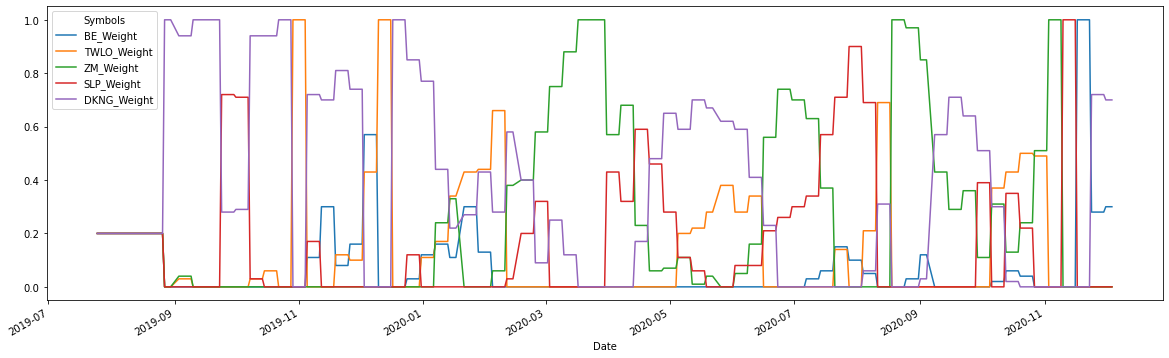

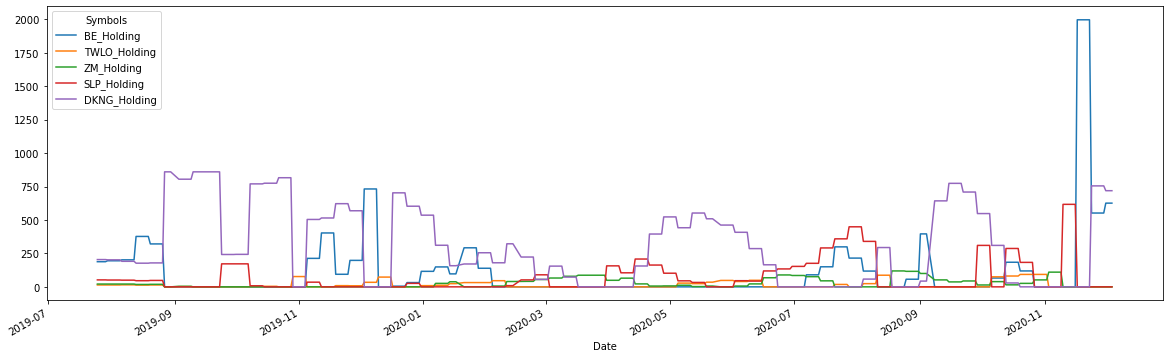

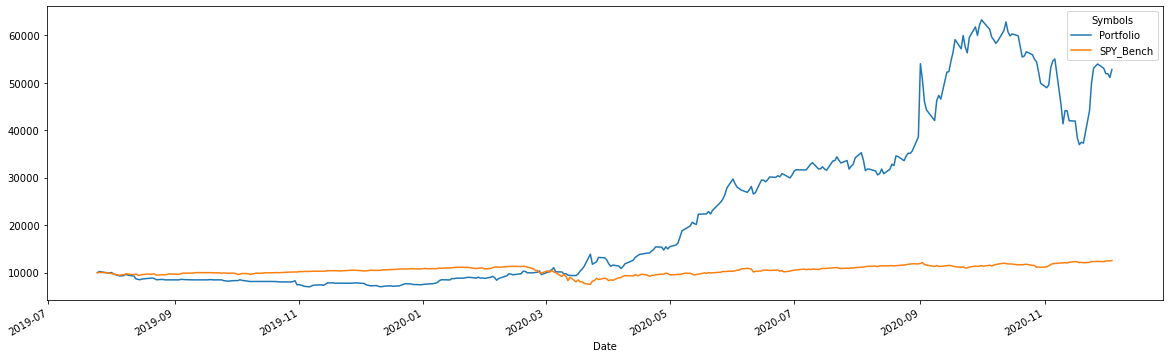

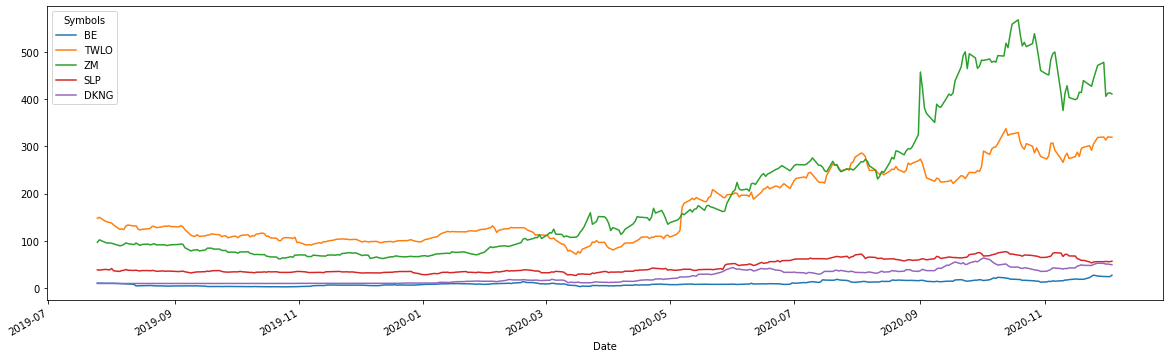

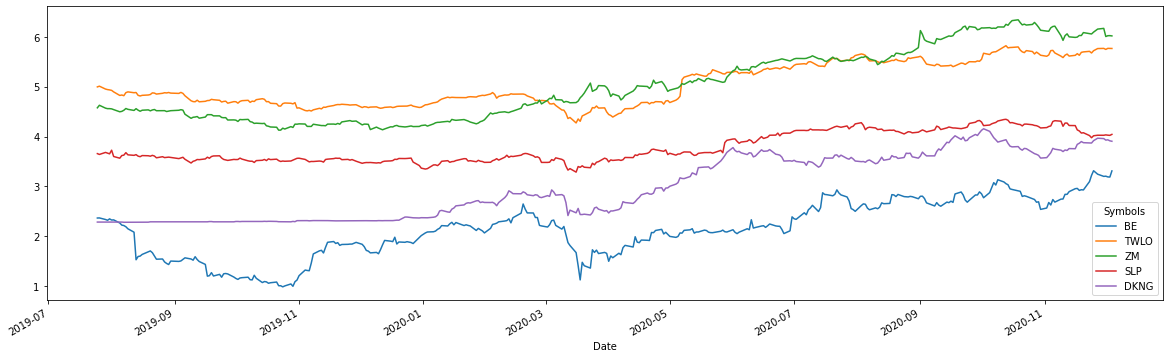

In [11]:
%matplotlib inline
#stock_new.plot()
stock_new[["BE_Weight","TWLO_Weight", "ZM_Weight", "SLP_Weight", "DKNG_Weight"]].plot(figsize=(20, 6))
stock_new[["BE_Holding","TWLO_Holding", "ZM_Holding", "SLP_Holding", "DKNG_Holding"]].plot(figsize=(20, 6))
stock_new[["Portfolio", "SPY_Bench"]].plot(figsize=(20, 6))
stock_new[["BE","TWLO", "ZM", "SLP", "DKNG"]].plot(figsize=(20, 6))
np.log(stock_new[["BE","TWLO", "ZM", "SLP", "DKNG"]]).plot(figsize=(20, 6))

In [14]:
#Calculate holding based on real Portfolio
current_total = 14400
get_holding(current_total, opt_results.x)

(156.0, 0.0, 0.0, 0.0, 204.0)

In [15]:
#Caculate hoding difference
208-199

9

In [16]:
stock_new.to_csv("Portfolio_Backtest_Result.csv")

In [17]:
#Portflio performance
max_cash=stock_new["Portfolio"].max()
min_cash=stock_new["Portfolio"].min()
final_cash=stock_new["Portfolio"].tail(1)

In [18]:
print("Initial Cash: $",10000)
print("Max Cash: $", max_cash)
print("Min Casg: $",min_cash)
print("Final Cash: $",final_cash)

Initial Cash: $ 10000
Max Cash: $ 63286.28045654297
Min Casg: $ 6999.739921092987
Final Cash: $ Date
2020-12-04    52814.42614
Name: Portfolio, dtype: float64


In [31]:
#Portflio evaluation
#https://www.investopedia.com/articles/07/sharpe_ratio.asp#:~:text=Using%20the%20Sharpe%20Ratio,A%20is%20a%20better%20performer.
#https://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp#:~:text=A%20maximum%20drawdown%20(MDD)%20is,over%20a%20specified%20time%20period.
daily_return = np.log(stock_new["Portfolio"]/stock_new["Portfolio"].shift(1))
#daily_return = stock_new["Portfolio"]-stock_new["Portfolio"].shift(1)
ret = daily_return.mean()
vol = daily_return.std()
sr = ret/vol

def MaxDrawdown(return_list):
    a = np.maximum.accumulate(return_list)
    l = np.argmax((a - return_list) /a)
    k = np.argmax(return_list[:l])
    return (return_list[k] - return_list[l])/(return_list[k])

return_list = list(stock_new["Portfolio"])
mdd = MaxDrawdown(return_list)
drawdown = round(mdd*100)


In [32]:
# portflio return,portflio volatility,portflio sharpe ratio
print("Expected Average Return :",round(ret*100,2),"%")
print("Expected Volatility:", round(vol*100,2),"%")
print("Sharpe Ratio:",round(sr*100,2),"%")
print("Max Drawdown:",drawdown,"%")

Expected Average Return : 0.48 %
Expected Volatility: 4.15 %
Sharpe Ratio: 11.63 %
Max Drawdown: 42 %


In [41]:
live_price = pd.read_csv("live trading.csv")["Price"].dropna()
live_daily_return = np.log(live_price/live_price.shift(1))
live_ret = live_daily_return.mean()
live_vol = live_daily_return.std()
live_sr = live_ret/vol

return_live = list(live_price)
mdd_live = MaxDrawdown(return_live)
drawdown_live = round(mdd_live*100)

In [42]:
print("Expected Average Return :",round(live_ret*100,2),"%")
print("Expected Volatility:", round(live_vol*100,2),"%")
print("Sharpe Ratio:",round(live_sr*100,2),"%")
print("Max Drawdown:",drawdown_live,"%")

Expected Average Return : 0.48 %
Expected Volatility: 4.15 %
Sharpe Ratio: 11.63 %
Max Drawdown: 5 %
